In [1]:
!pip -q install wfdb imbalanced-learn

import os
import wfdb
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D, Dropout , Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Bidirectional,BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score
import pandas as pd
import seaborn as sns
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 110.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    project_directory = '/content/drive/MyDrive/Colab Notebooks/MIT-BIH/physionet.org/files/mitdb/1.0.0/'  # Change this path to match your Google Drive directory
    os.chdir(project_directory)



except:
    pass

Mounted at /content/drive


In [3]:
# Inicializar uma lista vazia para guardar os números dos registos
list_records = []

# Obter uma lista de todos os ficheiros no diretório atual
file_list = os.listdir('.')

# Iterar sobre cada nome de ficheiro na lista de ficheiros
for file_name in file_list:
    # Dividir o nome do ficheiro pelo ponto para separar as partes
    parts = file_name.split(".")

    # Verificar se a primeira parte do nome é um número
    if parts[0].isdigit():
        # Se for um número, adicionar à lista de registos
        list_records.append(parts[0])

        # Construir o caminho para o ficheiro de registo
        record_path = f'./{parts[0]}'

        # Ler o registo ECG do caminho especificado, limitando a leitura a 3000 amostras
        record = wfdb.rdrecord(record_path, sampto=3000)

        # Extrair o sinal ECG da primeira derivação do registo
        ecg_signal = record.p_signal[:,0]

        # Iniciar uma nova figura para o plot
        plt.figure()

        # Imprimir o sinal ECG
        plt.plot(ecg_signal)

        # Definir o título do gráfico com o número do registo
        plt.title(f'Sinal ECG para {parts[0]}')

        # Definir a etiqueta do eixo X
        plt.xlabel('Pontos de Amostra')

        # Definir a etiqueta do eixo Y
        plt.ylabel('Amplitude')

        # Mostrar o gráfico
        plt.show()

In [4]:
# Inicializar uma lista vazia para armazenar as anotações dos registos
annotations = []

# Iterar sobre cada nome de registo armazenado na lista 'list_records'
for record_name in list_records:
    # Construir o caminho para o ficheiro de registo
    record_path = f'./{record_name}'

    # Ler o sinal ECG do registo especificado, extrair apenas a primeira derivação
    record = wfdb.rdrecord(record_path).p_signal[:,0]

    # Tentativa de ler a anotação associada ao registo
    try:
        # Ler o ficheiro de anotação 'atr' associado ao registo
        ann = wfdb.rdann(record_path, 'atr')

        # Adicionar o objeto de anotação à lista de anotações
        annotations.append(ann)

    # Capturar o erro caso o ficheiro de anotação 'atr' não seja encontrado
    except FileNotFoundError:
        # Imprimir uma mensagem de erro indicando que não foi encontrada anotação
        print(f"Nenhuma anotação 'atr' encontrada para o registo {record_name}")

In [ ]:
# Inicialização de listas para armazenar intervalos R-R e as respetivas etiquetas de classificação
X = []  # Intervalos R-R
y = []  # Etiquetas (0: normal, 1: V, 2: A, etc.)

# Definição do tamanho da janela de análise
window_size = 10

# Definir anotações de doenças e sua codificação numérica
disease_annotations = {
    'N': 0,  # Normal
    'V': 1,  # Extrassístoles Ventriculares
    'A': 2, 'a': 2,  # Extrassístoles Auriculares
    'L': 3, 'R': 3,  # Bloqueios AV
    'j': 4, 'e': 4, 'E': 4,  # Ritmos de Escape Juncionais e Ventriculares
    'F': 5,  # Taquicardia Ventricular
    'f': 6, '[': 6, ']': 6,  # Flutter Auricular e Fibrilação
    'x': 7  # Bloqueios AV de Segundo/Terceiro Grau
}

# Iterar sobre cada registo na lista de registos
for record_name in list_records:
    # Carregar o sinal e as anotações correspondentes
    annotation = wfdb.rdann(f'./{record_name}', 'atr')

    # Detectar picos no sinal
    peaks = annotation.sample

    # Obter os intervalos R-R a partir dos picos detetados
    intervals = np.diff(peaks)

    # Normalizar os intervalos R-R pelo valor máximo
    normalized_intervals = intervals / intervals.max()

    # Dividir os intervalos normalizados em segmentos de tamanho definido pela 'window_size'
    for i in range(len(intervals) - window_size + 1):
        # Obter as anotações e intervalos para a janela atual
        window_annotations = annotation.symbol[i:i + window_size]
        window_intervals = normalized_intervals[i:i + window_size]

        # Determinar a anotação mais frequente dentro da janela
        most_common_annotation = max(set(window_annotations), key=window_annotations.count)

        # Atribuir uma etiqueta com base na anotação mais comum
        label = disease_annotations.get(most_common_annotation, 0)  # Por defeito é 0 (normal) se não encontrada

        # Adicionar os dados às listas X e y
        X.append(window_intervals)
        y.append(label)


Text(0, 0.5, 'disease score')

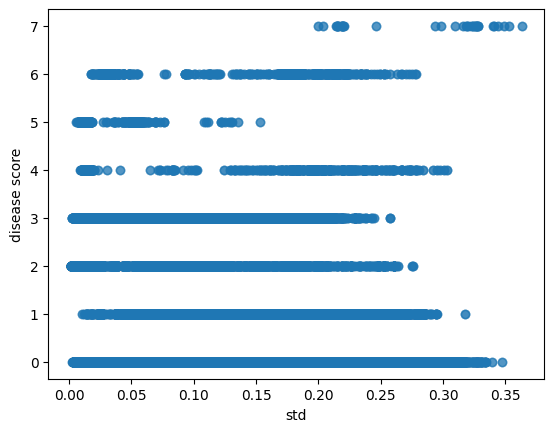

In [ ]:
# Converter as listas X e y para arrays numpy para facilitar manipulações matemáticas e plotagem
X = np.array(X)
y = np.array(y)

# Criar um gráfico de dispersão onde o eixo X representa o desvio padrão dos intervalos R-R em cada segmento
# e o eixo Y representa as etiquetas de doenças codificadas numericamente
plt.scatter(np.std(X, axis=1), y, alpha=0.3)

# Definir a etiqueta do eixo X como 'std', que indica o desvio padrão dos intervalos R-R
plt.xlabel("std")

# Definir a etiqueta do eixo Y como 'disease score', que corresponde às categorias de doenças
plt.ylabel("disease score")


Text(0, 0.5, 'Contagem')

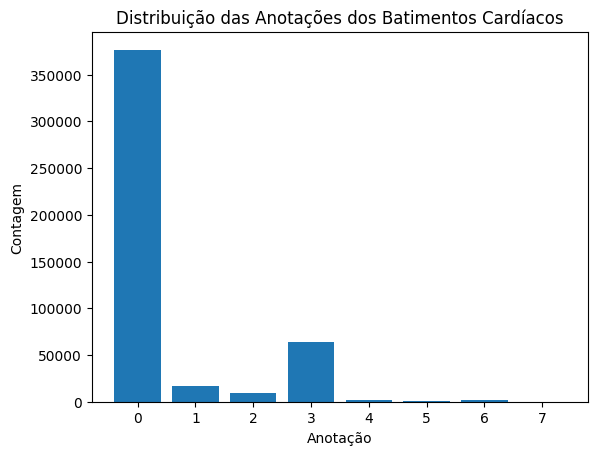

In [ ]:
# Inicializar um contador para contabilizar as frequências das anotações de doenças
annotation_counter = Counter()

# Atualizar o contador com as etiquetas de doença presentes no array y
annotation_counter.update(y)

# Criar um gráfico de barras para visualizar a distribuição das anotações de doença
plt.bar(annotation_counter.keys(), annotation_counter.values())

# Definir o título do gráfico, enfatizando que ele mostra a distribuição das anotações dos batimentos cardíacos
plt.title('Distribuição das Anotações dos Batimentos Cardíacos')

# Definir a etiqueta do eixo X como 'Annotation', indicando os diferentes tipos de anotações
plt.xlabel('Anotação')

# Definir a etiqueta do eixo Y como 'Count', indicando a contagem de cada anotação
plt.ylabel('Contagem')


In [ ]:
# Primeira divisão: Dividindo em 70% para treino, 30% para teste + validação
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Segunda divisão: Dividindo os 30% em 15% teste e 15% validação
X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

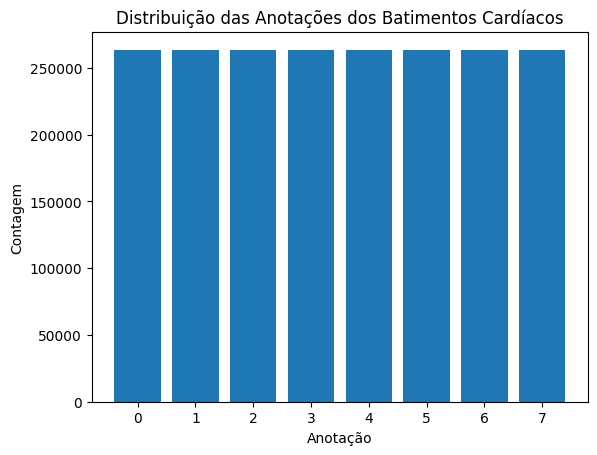

In [ ]:
# Corrigir o desequilíbrio de classes utilizando a técnica SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE()

# Ajustar o SMOTE aos dados de treino para criar exemplos sintéticos e equilibrar as classes
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Inicializar um contador para contabilizar as frequências das anotações após o reamostragem com SMOTE
annotation_smote_counter = Counter()
annotation_smote_counter.update(y_train_smote)

# Definir o número de classes existentes nos dados
num_classes = 8

# Converter as etiquetas y para o formato categórico, necessário para modelos de classificação multiclasse
y_train_smote = to_categorical(y_train_smote, num_classes=num_classes)
y_validation = to_categorical(y_validation, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Criar um gráfico de barras para visualizar a distribuição das anotações após a reamostragem
plt.bar(annotation_smote_counter.keys(), annotation_smote_counter.values())
plt.title('Distribuição das Anotações dos Batimentos Cardíacos')
plt.xlabel('Anotação')
plt.ylabel('Contagem')
plt.show()  # Mostrar o gráfico

# Definir o caminho para salvar os modelos treinados dentro do diretório do projeto
output_path = os.path.join(project_directory, 'models')


In [ ]:
# Definição do modelo LSTM para análise de séries temporais, como sinais de ECG
model_lstm = Sequential([
        # Adicionar uma camada LSTM com 512 unidades, retornando sequências para a próxima camada LSTM,
        # com regularização L2 para reduzir o overfitting
        LSTM(512, return_sequences=True, input_shape=(window_size,1), kernel_regularizer=l2(0.01)),

        # Adicionar dropout para reduzir o overfitting ao descartar aleatoriamente conexões durante o treinamento
        Dropout(0.3),

        # Normalização de batch para acelerar o treinamento e melhorar a performance do modelo
        BatchNormalization(),

        # Segunda camada LSTM com 256 unidades, também com retorno de sequências
        LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        BatchNormalization(),

        # Terceira camada LSTM com 128 unidades, sem retorno de sequências
        LSTM(128, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        BatchNormalization(),

        # Camada densa com 512 unidades e ativação ReLU
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),

        # Outra camada densa com 256 unidades e ativação ReLU
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),

        # Camada de saída com 8 unidades, uma para cada classe, usando a função de ativação sigmoid
        Dense(8, activation='sigmoid')
    ])

# Compilar o modelo com o otimizador Adam, usando uma taxa de aprendizagem de 0.001,
# e configurando a função de perda como 'binary_crossentropy' para classificação binária multiclasse,
# e medindo a precisão do modelo
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


model_lstm
Epoch 1/100
65829/65829 ━━━━━━━━━━━━━━━━━━━━ 905s 14ms/step - accuracy: 0.6568 - loss: 0.2876 - val_accuracy: 0.4176 - val_loss: 0.3036 - learning_rate: 0.0010
Epoch 2/100
65829/65829 ━━━━━━━━━━━━━━━━━━━━ 919s 14ms/step - accuracy: 0.8167 - loss: 0.1573 - val_accuracy: 0.4909 - val_loss: 0.3031 - learning_rate: 0.0010
Epoch 3/100
65829/65829 ━━━━━━━━━━━━━━━━━━━━ 938s 14ms/step - accuracy: 0.8521 - loss: 0.1424 - val_accuracy: 0.5166 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 4/100
65829/65829 ━━━━━━━━━━━━━━━━━━━━ 904s 14ms/step - accuracy: 0.8727 - loss: 0.1335 - val_accuracy: 0.6115 - val_loss: 0.2855 - learning_rate: 0.0010
Epoch 5/100
65829/65829 ━━━━━━━━━━━━━━━━━━━━ 893s 14ms/step - accuracy: 0.8860 - loss: 0.1266 - val_accuracy: 0.6145 - val_loss: 0.2418 - learning_rate: 0.0010
Epoch 6/100
65829/65829 ━━━━━━━━━━━━━━━━━━━━ 882s 13ms/step - accuracy: 0.8942 - loss: 0.1232 - val_accuracy: 0.6706 - val_loss: 0.2275 - learning_rate: 0.0010
Epoch 7/100
65829/65829 ━━━━━

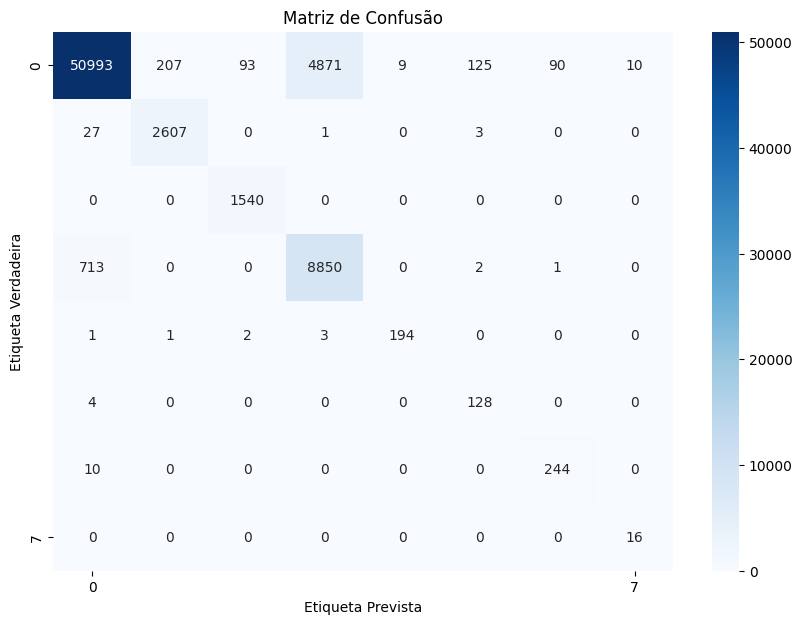

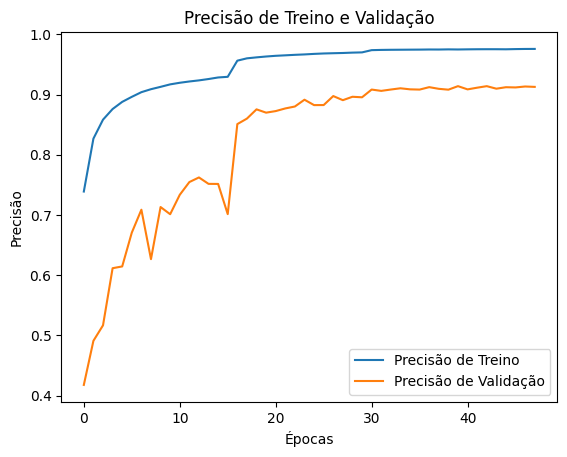

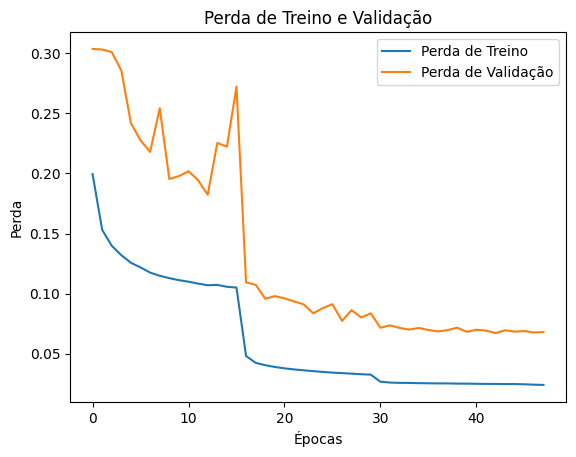

In [ ]:
class_descriptions = {
    0: 'N',
    1: 'E',
    2: 'A',
    3: 'B',
    4: 'R',
    5: 'T',
    6: 'F',
    7: 'V'
}

print("model_lstm")
# Treinar o modelo com callbacks para EarlyStopping e ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),  # Parar cedo se não houver melhoria
    ReduceLROnPlateau(factor=0.1, patience=3)  # Reduzir a taxa de aprendizagem se estagnado
]
history = model_lstm.fit(
    X_train_smote,  # Dados de treino balanceados por SMOTE
    y_train_smote,  # Etiquetas de treino balanceadas
    validation_data=(X_validation, y_validation),  # Dados de validação
    epochs=100,  # Número total de épocas
    batch_size=32,  # Tamanho do lote
    verbose=1,  # Mostrar progresso
    callbacks=callbacks  # Callbacks definidos anteriormente
)

# Avaliar o modelo nos dados de teste e imprimir a precisão e perda
loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {accuracy}')
print(f'Loss: {loss}')

# Prever no conjunto de teste
y_pred = model_lstm.predict(X_test)
# Converter as previsões para etiquetas categóricas
y_pred_labels = np.argmax(y_pred, axis=1) if y_pred.shape[1] > 1 else (y_pred > 0.5).astype(int)
# A linha seguinte foi alterada para resolver o erro
y_true_labels = np.argmax(y_test, axis=1)  # Converter as verdadeiras etiquetas para formato categórico
# Calcular a precisão geral
accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Calcular métricas por classe
precision_per_class = precision_score(y_true_labels, y_pred_labels, average=None)  # Precisão por classe
recall_per_class = recall_score(y_true_labels, y_pred_labels, average=None)  # Recall por classe
f1_per_class = f1_score(y_true_labels, y_pred_labels, average=None)  # F1-Score por classe

# Exibir resultados para cada classe
print(f"Model: model_lstm")
print(f"Overall Accuracy: {accuracy:.2f}")
for idx, (prec, rec, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f"Class {idx}: Precision: {prec:.2f}, Recall: {rec:.2f}, F1-Score: {f1:.2f}")

# Opcionalmente, armazenar resultados de forma estruturada em um DataFrame
results = []
for idx, (prec, rec, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    results.append({
        'Model': "model_lstm",
        'Class': idx,
        'Accuracy': accuracy,  # Precisão geral, igual para cada classe
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
df_results = pd.DataFrame(results)

# Reformatar DataFrame para o formato desejado: uma linha por classe, colunas por modelo
pivot_table = df_results.pivot_table(index=['Class'], columns=['Model'], values=['Precision', 'Recall', 'F1-Score', 'Accuracy'])
print(pivot_table)

# Calcular a matriz de confusão
cm = confusion_matrix(y_true_labels, y_pred_labels)  # Matriz de confusão entre etiquetas verdadeiras e previstas

# 'classes_listed' é uma lista com os nomes das classes
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx, yticklabels=idx)
plt.title('Matriz de Confusão')
plt.xlabel('Etiqueta Prevista')
plt.ylabel('Etiqueta Verdadeira')
plt.show()

# Imprimir a precisão de treino e validação ao longo das épocas
plt.plot(history.history['accuracy'], label='Precisão de Treino')
plt.plot(history.history['val_accuracy'], label='Precisão de Validação')
plt.title('Precisão de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.show()

# Imprimir a perda de treino e validação ao longo das épocas
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Guardar o modelo treinado no caminho especificado
save_path = os.path.join(output_path,'model_lstm.h5')
model_lstm.save(save_path)